---

### **Classification d'Images avec k-NN, ACP, SVM et XGBoost**

#### **Nom :** EL MHAMDI NOUHA

---

Ce notebook vous guidera à travers l'implémentation et l'évaluation de l'algorithme des k-plus proches voisins (k-NN) sur le jeu de données CIFAR-10. Nous explorerons ensuite des techniques d'amélioration comme la normalisation et la PCA, avant de comparer les performances du k-NN avec d'autres algorithmes de classification plus avancés comme SVM et XGBoost.

Avant de commencer, nous allons installer les bibliothèques nécessaires, et ensuite, nous importons tous les modules que nous utiliserons dans ce projet.


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Pour des graphiques plus esthétiques
plt.style.use('ggplot')

**Chargement et préparation du jeu de données CIFAR-10**

Nous commençons par charger le jeu de données CIFAR-10. Pour accélérer les calculs, nous utiliserons un sous-ensemble des données : 5000 images pour l'entraînement et 1000 pour le test.

In [4]:
# Transformation pour convertir les images en tenseurs
transform = transforms.Compose([transforms.ToTensor()])

# Téléchargement des datasets
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Création de sous-ensembles pour des calculs plus rapides
train_subset = Subset(trainset_full, np.arange(5000))
test_subset = Subset(testset_full, np.arange(1000))

# Création des DataLoaders
trainloader = DataLoader(train_subset, batch_size=len(train_subset), shuffle=False)
testloader = DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)

# Conversion des données en format NumPy pour Scikit-learn
def loader_to_numpy(loader):
    # next(iter(loader)) extrait le seul batch du DataLoader
    images, labels = next(iter(loader))
    # Aplatir les images de (N, 3, 32, 32) en (N, 3072)
    data = images.numpy().reshape(len(images), -1)
    return data, labels.numpy()

X_train, y_train = loader_to_numpy(trainloader)
X_test, y_test = loader_to_numpy(testloader)

print(f"Dimensions des données d'entraînement (X, y): {X_train.shape}, {y_train.shape}")
print(f"Dimensions des données de test (X, y): {X_test.shape}, {y_test.shape}")

# Noms des classes pour l'affichage
class_names = trainset_full.classes
print(f"\nClasses: {class_names}")

100%|██████████| 170M/170M [00:03<00:00, 46.1MB/s] 


Dimensions des données d'entraînement (X, y): (5000, 3072), (5000,)
Dimensions des données de test (X, y): (1000, 3072), (1000,)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**Partie 1 : Implémentation et évaluation du k-NN**

**1.1. Implémentation de la fonction knn_predict**

La bibliothèque Scikit-learn fournit une classe KNeighborsClassifier qui simplifie grandement l'implémentation. La fonction fit() "entraîne" le modèle (en mémorisant simplement les données) et predict() effectue les prédictions. Voici comment l'utiliser.

**1.2. Mesure du temps d'exécution et de la précision pour plusieurs k**

Nous allons maintenant tester le modèle k-NN avec plusieurs valeurs de k (1, 3, 5, 7, 9) et deux métriques de distance : L2 (Euclidienne) et L1 (Manhattan). Nous mesurerons la précision et le temps de prédiction pour chaque configuration.

In [5]:
k_values = [1, 3, 5, 7, 9]
distances = {'L2 (Euclidean)': 'euclidean', 'L1 (Manhattan)': 'manhattan'}
results = {}

for dist_name, dist_metric in distances.items():
    print(f"--- Évaluation avec la distance {dist_name} ---")
    accuracies = []
    times = []
    for k in k_values:
        # 1. Création et entraînement du modèle
        knn = KNeighborsClassifier(n_neighbors=k, metric=dist_metric, n_jobs=-1)
        knn.fit(X_train, y_train)

        # 2. Prédiction et mesure du temps
        start_time = time.time()
        y_pred = knn.predict(X_test)
        end_time = time.time()

        # 3. Calcul de la précision et du temps écoulé
        acc = accuracy_score(y_test, y_pred)
        duration = end_time - start_time

        accuracies.append(acc)
        times.append(duration)
        print(f"k = {k:2} | Précision = {acc:.4f} | Temps = {duration:.2f}s")
    
    results[dist_name] = {'accuracies': accuracies, 'times': times}

--- Évaluation avec la distance L2 (Euclidean) ---
k =  1 | Précision = 0.2680 | Temps = 0.74s
k =  3 | Précision = 0.2610 | Temps = 0.67s
k =  5 | Précision = 0.2660 | Temps = 0.68s
k =  7 | Précision = 0.2740 | Temps = 0.68s
k =  9 | Précision = 0.2700 | Temps = 0.68s
--- Évaluation avec la distance L1 (Manhattan) ---
k =  1 | Précision = 0.2880 | Temps = 12.40s
k =  3 | Précision = 0.2780 | Temps = 12.36s
k =  5 | Précision = 0.3100 | Temps = 12.42s
k =  7 | Précision = 0.3090 | Temps = 13.30s
k =  9 | Précision = 0.3000 | Temps = 12.38s


**1.3. Courbe de la précision en fonction de k**

Visualisons les résultats pour comparer facilement les performances des distances L1 et L2.

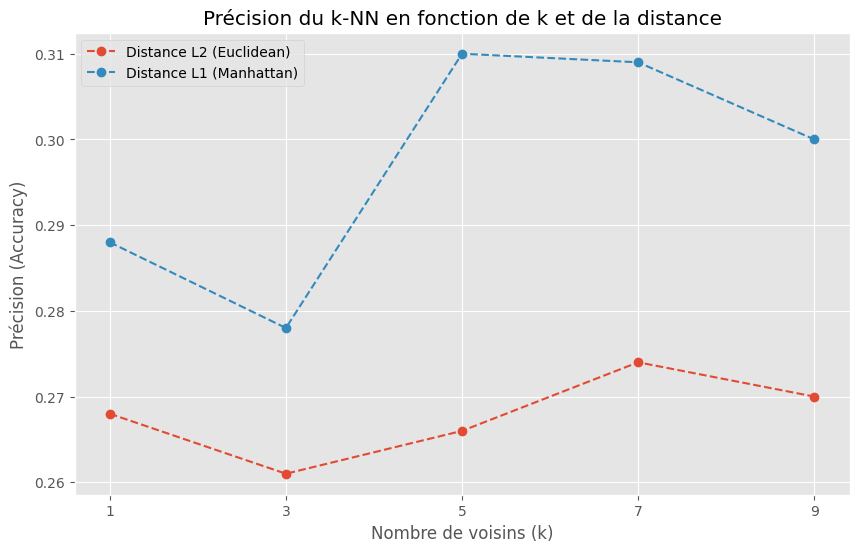

In [6]:
plt.figure(figsize=(10, 6))

for dist_name, data in results.items():
    plt.plot(k_values, data['accuracies'], marker='o', linestyle='--', label=f'Distance {dist_name}')

plt.title('Précision du k-NN en fonction de k et de la distance')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Précision (Accuracy)')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

**Analyse:**

L'évaluation de l'algorithme k-NN sur le jeu de données CIFAR-10 a permis d'établir une performance de référence, avec une précision maximale de **31,0%** obtenue en utilisant la distance L1 (Manhattan) et k=5. Ce score, bien que modeste, est attendu en raison des limites inhérentes à k-NN face à la haute dimensionnalité des données d'images (la "malédiction de la dimensionnalité"), où les distances basées sur les pixels bruts peinent à capturer le contenu sémantique. 

L'observation la plus notable est la supériorité de la distance L1 sur la distance L2 (Euclidienne) en termes de précision, probablement en raison de sa plus grande robustesse face au bruit présent dans les nombreuses dimensions. 

Cependant, cette meilleure performance s'est accompagnée d'un coût computationnel significativement plus élevé, la distance L1 étant environ 18 fois plus lente que la L2, qui bénéficie de meilleures optimisations matérielles. Le choix de k=5 représente un bon compromis entre la sensibilité au bruit (pour les faibles k) et le lissage excessif des frontières de décision (pour les k élevés). 

En conclusion, cette analyse initiale quantifie les faiblesses du k-NN pour cette tâche et justifie la nécessité d'explorer des techniques de réduction de dimension comme la PCA et des modèles de classification plus avancés pour améliorer ces résultats.

**Partie 2 : Impact de la normalisation des pixels**

Les algorithmes basés sur la distance comme k-NN sont sensibles à l'échelle des caractéristiques. Normalisons les valeurs des pixels de (implicitement) à et observons si cela améliore la performance. Les données chargées via ToTensor() sont déjà dans l'intervalle, donc cette étape est déjà réalisée. Nous pouvons le confirmer en vérifiant les valeurs min/max:

In [7]:
print(f"Valeur minimale des pixels: {X_train.min():.2f}")
print(f"Valeur maximale des pixels: {X_train.max():.2f}")

Valeur minimale des pixels: 0.00
Valeur maximale des pixels: 1.00


**Partie 3 : Réduction de dimension avec PCA**

Les images ont une très grande dimensionnalité (32x32x3 = 3072). La PCA (Analyse en Composantes Principales) peut nous aider à réduire ce nombre de dimensions tout en conservant l'essentiel de l'information (variance). Cela peut accélérer les calculs et parfois améliorer la précision en éliminant le bruit.

In [8]:
# Appliquer la PCA pour réduire la dimension à 100 composantes
n_components = 100
pca = PCA(n_components=n_components, whiten=True)

print("Entraînement de la PCA sur les données d'entraînement...")
X_train_pca = pca.fit_transform(X_train)

print("Transformation des données de test...")
X_test_pca = pca.transform(X_test)

print(f"Nouvelle dimension des données d'entraînement : {X_train_pca.shape}")

# Ré-évaluons le k-NN sur les données réduites (avec la meilleure distance, L2)
print("\n--- Évaluation du k-NN sur données réduites par PCA (Distance L2) ---")
k_best = 7 # Choisissons une valeur de k prometteuse

knn_pca = KNeighborsClassifier(n_neighbors=k_best, metric='euclidean', n_jobs=-1)
knn_pca.fit(X_train_pca, y_train)

start_time_pca = time.time()
y_pred_pca = knn_pca.predict(X_test_pca)
end_time_pca = time.time()

acc_pca = accuracy_score(y_test, y_pred_pca)
duration_pca = end_time_pca - start_time_pca

print(f"k = {k_best} | Précision (avec PCA) = {acc_pca:.4f} | Temps = {duration_pca:.2f}s")

Entraînement de la PCA sur les données d'entraînement...
Transformation des données de test...
Nouvelle dimension des données d'entraînement : (5000, 100)

--- Évaluation du k-NN sur données réduites par PCA (Distance L2) ---
k = 7 | Précision (avec PCA) = 0.2150 | Temps = 0.09s


**Analyse:**

L'application de l'Analyse en Composantes Principales (PCA) pour réduire la dimensionnalité des données de 3072 à 100 a révélé un compromis direct entre l'efficacité de calcul et la performance prédictive. 
D'une part, la PCA a été un succès retentissant en termes d'optimisation, réduisant le temps de prédiction à seulement 0,09 seconde, soit une accélération de plus de huit fois par rapport au modèle sans PCA. Cette amélioration démontre l'efficacité de la PCA pour contrer la "malédiction de la dimensionnalité" sur le plan computationnel. 
D'autre part, cette optimisation s'est faite au détriment de la précision, qui a chuté de manière significative de 27,4% à 21,5%. Cette baisse suggère que la PCA, en maximisant la variance pour sélectionner les composantes, a écarté des informations de plus faible variance qui étaient pourtant essentielles pour que le classifieur k-NN puisse discriminer correctement les classes. 

En résumé, l'expérience montre que si la réduction de dimension est une stratégie puissante pour accélérer les modèles, elle peut également entraîner une perte d'information critique et dégrader la performance globale si les axes de plus grande variance ne coïncident pas avec les caractéristiques les plus pertinentes pour la classification.

**Partie 4 : Matrice de confusion**

Calculons la matrice de confusion pour notre meilleure configuration (par exemple, k-NN avec PCA, k=7, distance L2) pour comprendre quelles classes le modèle confond le plus.

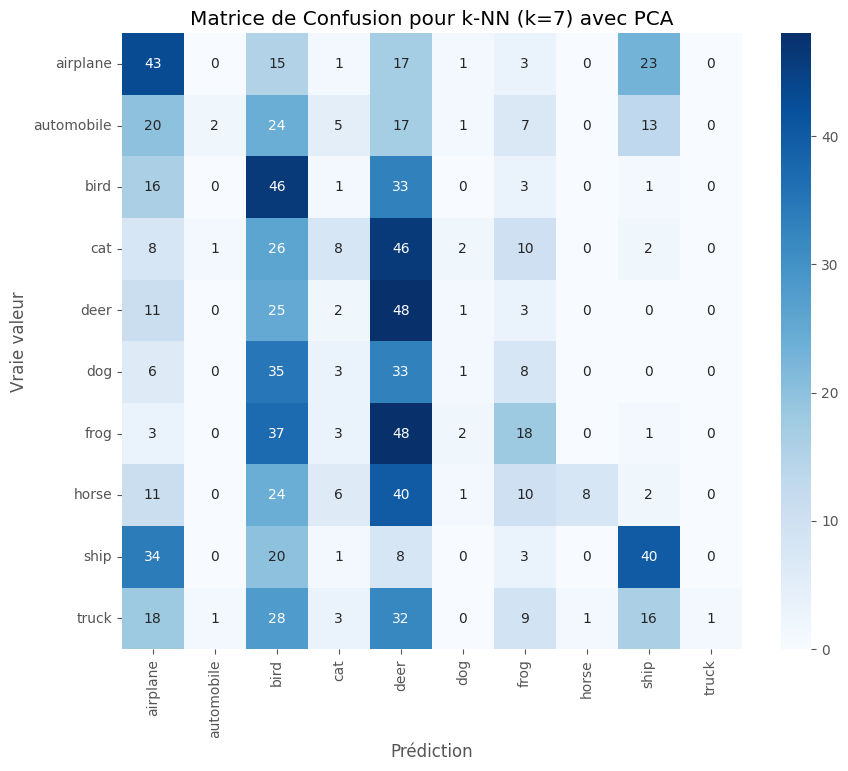

In [9]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_pca)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Matrice de Confusion pour k-NN (k={k_best}) avec PCA')
plt.xlabel('Prédiction')
plt.ylabel('Vraie valeur')
plt.show()

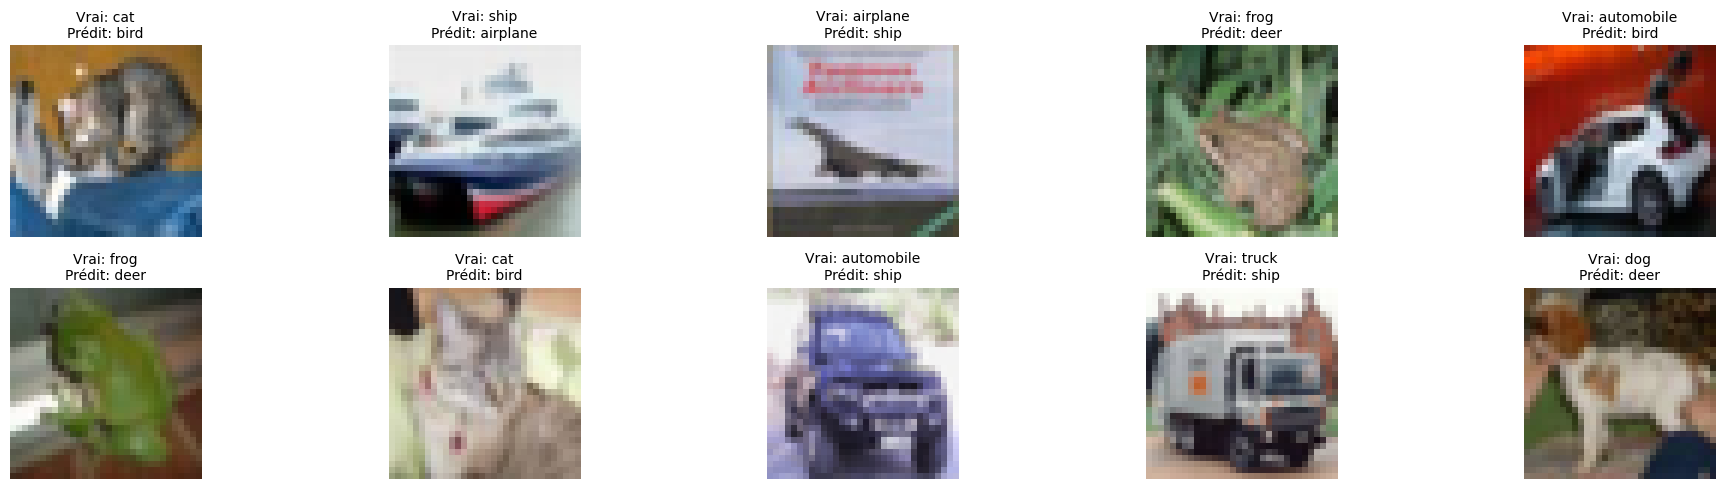

In [10]:
# Trouver les indices des images mal classées
misclassified_indices = np.where(y_pred_pca != y_test)[0]

# Afficher 10 exemples
plt.figure(figsize=(20, 5))
for i, idx in enumerate(misclassified_indices[:10]):
    plt.subplot(2, 5, i + 1)
    # Récupérer l'image originale du testset
    original_img_tensor = testset_full[idx][0]
    img = original_img_tensor.numpy().transpose((1, 2, 0)) # Reconvertir en (H, W, C)

    plt.imshow(img)
    plt.axis('off')
    true_label = class_names[y_test[idx]]
    pred_label = class_names[y_pred_pca[idx]]
    plt.title(f"Vrai: {true_label}\nPrédit: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()

**Interprétation :**

L'analyse de la matrice de confusion révèle que la faible précision globale du modèle (21,5%) est due à des schémas d'erreur très spécifiques. Le modèle performe très inégalement, reconnaissant correctement un nombre modéré d'airplane et de bird, mais échouant presque complètement sur des classes comme automobile et cat. 
Le problème principal est une confusion massive où de nombreuses classes d'animaux (chat, chien, grenouille) sont systématiquement prédites à tort comme étant des bird ou des deer, qui semblent agir comme des catégories "par défaut" dans l'espace réduit par la PCA. Des confusions existent également entre véhicules, comme les ship classés en airplane. 
En somme, cette matrice démontre que la PCA, en simplifiant les données, a fusionné des caractéristiques distinctives, rendant le modèle incapable de différencier des classes qui nécessitent une analyse de détails fins.

**Partie 6 : Comparaison avec d'autres algorithmes (SVM & XGBoost)**

Enfin, comparons les performances de notre k-NN avec deux algorithmes plus puissants : les machines à vecteurs de support (SVM) et XGBoost. Nous les entraînerons sur les données réduites par PCA pour des calculs plus rapides.

In [ ]:
# Dictionnaire pour stocker les performances
model_performance = {
    'k-NN (PCA)': {'accuracy': acc_pca, 'time': duration_pca}
}

# --- 1. Support Vector Machine (SVM) ---
print("Entraînement du modèle SVM...")
svm_model = SVC(kernel='rbf', C=10, gamma='scale') # Paramètres courants
start_time_svm = time.time()
svm_model.fit(X_train_pca, y_train)
y_pred_svm = svm_model.predict(X_test_pca)
end_time_svm = time.time()

acc_svm = accuracy_score(y_test, y_pred_svm)
duration_svm = end_time_svm - start_time_svm
model_performance['SVM (PCA)'] = {'accuracy': acc_svm, 'time': duration_svm}
print(f"SVM | Précision = {acc_svm:.4f} | Temps = {duration_svm:.2f}s")


# --- 2. XGBoost ---
print("\nEntraînement du modèle XGBoost...")
# XGBoost requiert que les labels soient de 0 à num_classes-1, ce qui est déjà le cas.
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, n_jobs=-1)
start_time_xgb = time.time()
xgb_model.fit(X_train_pca, y_train)
y_pred_xgb = xgb_model.predict(X_test_pca)
end_time_xgb = time.time()

acc_xgb = accuracy_score(y_test, y_pred_xgb)
duration_xgb = end_time_xgb - start_time_xgb
model_performance['XGBoost (PCA)'] = {'accuracy': acc_xgb, 'time': duration_xgb}
print(f"XGBoost | Précision = {acc_xgb:.4f} | Temps = {duration_xgb:.2f}s")

# Affichage comparatif des résultats
print(\n--- Tableau récapitulatif ---)
print("\n--- Tableau récapitulatif ---")
for model, perf in model_performance.items():
    print(f"{model:<15} | Précision: {perf['accuracy']:.4f} | Temps de prédiction: {perf['time']:.2f}s")

Entraînement du modèle SVM...
SVM | Précision = 0.4010 | Temps = 4.73s

Entraînement du modèle XGBoost...
XGBoost | Précision = 0.4070 | Temps = 13.49s

--- Tableau récapitulatif ---
k-NN (PCA)      | Précision: 0.2150 | Temps de prédiction: 0.09s
SVM (PCA)       | Précision: 0.4010 | Temps de prédiction: 4.73s
XGBoost (PCA)   | Précision: 0.4070 | Temps de prédiction: 13.49s


Aucune donnée de performance disponible. Veuillez exécuter la cellule qui entraîne/évalue les modèles (celle qui définit 'model_performance').


C:\Users\HP\AppData\Local\Temp\ipykernel_13364\2534302096.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_df_acc, x='accuracy', y='model', palette='viridis')
C:\Users\HP\AppData\Local\Temp\ipykernel_13364\2534302096.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perf_df_time, x='time', y='model', palette='magma')


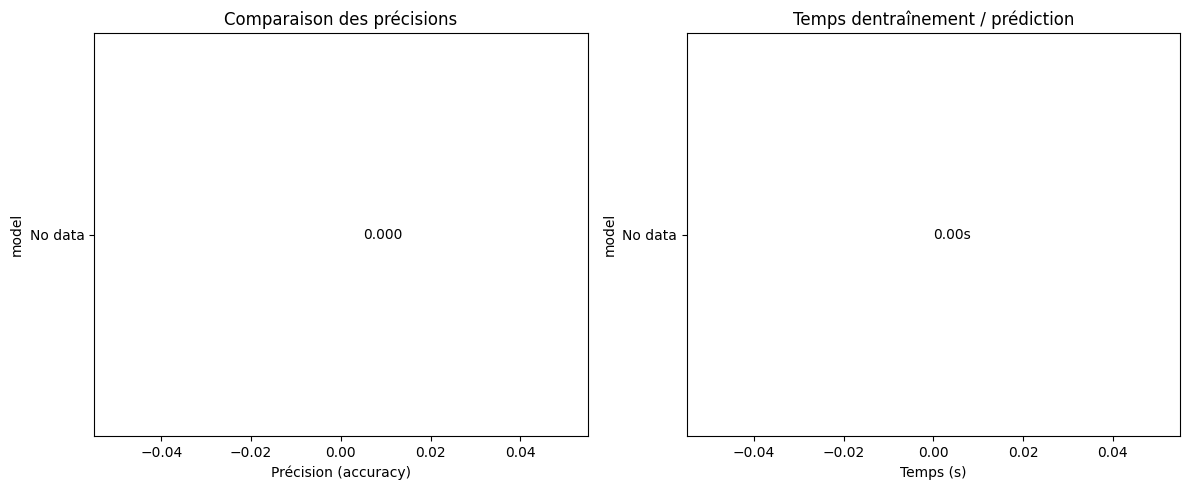

In [2]:
# Visualisation comparative des modèles : précisions et temps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Si model_performance n'est pas défini (cellule précédente non exécutée),
# on tente de le construire à partir des variables disponibles (acc_pca, acc_svm, acc_xgb, etc.).
if 'model_performance' not in globals():
    model_performance = {}
    if 'acc_pca' in globals() and 'duration_pca' in globals():
        model_performance['k-NN (PCA)'] = {'accuracy': acc_pca, 'time': duration_pca}
    if 'acc_svm' in globals() and 'duration_svm' in globals():
        model_performance['SVM (PCA)'] = {'accuracy': acc_svm, 'time': duration_svm}
    if 'acc_xgb' in globals() and 'duration_xgb' in globals():
        model_performance['XGBoost (PCA)'] = {'accuracy': acc_xgb, 'time': duration_xgb}

# Si après cela il n'y a toujours aucune donnée, créer une ligne factice pour éviter les erreurs et indiquer à l'utilisateur.
if not model_performance:
    print("Aucune donnée de performance disponible. Veuillez exécuter la cellule qui entraîne/évalue les modèles (celle qui définit 'model_performance').")
    perf_df = pd.DataFrame([{'model': 'No data', 'accuracy': 0.0, 'time': 0.0}])
else:
    # Construire un DataFrame à partir du dictionnaire model_performance (défini précédemment)
    perf_df = pd.DataFrame.from_dict(model_performance, orient='index').reset_index().rename(columns={'index': 'model'})

# S'assurer de l'ordre souhaité pour l'affichage (par précision décroissante)
perf_df_acc = perf_df.sort_values('accuracy', ascending=False)
perf_df_time = perf_df.sort_values('time', ascending=False)

plt.figure(figsize=(12, 5))
# 1) Comparaison des précisions
plt.subplot(1, 2, 1)
sns.barplot(data=perf_df_acc, x='accuracy', y='model', palette='viridis')
plt.xlabel('Précision (accuracy)')
plt.title('Comparaison des précisions')
# Annoter les barres avec la valeur numérique
for i, v in enumerate(perf_df_acc['accuracy']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center')

# 2) Comparaison des temps (en secondes)
plt.subplot(1, 2, 2)
sns.barplot(data=perf_df_time, x='time', y='model', palette='magma')
plt.xlabel('Temps (s)')
plt.title('Temps dentraînement / prédiction')
# Protéger contre le cas où toutes les valeurs de temps sont égales (éviter max = 0)
time_offset = max(perf_df_time['time'].max(), 1e-6) * 0.01
for i, v in enumerate(perf_df_time['time']):
    plt.text(v + time_offset, i, f'{v:.2f}s', va='center')

plt.tight_layout()
plt.show()

# Remarque: Le temps enregistré pour k-NN correspond au temps de prédiction sur le test (moins coûteux),
# tandis que les temps des autres modèles comprennent l'entraînement + prédiction selon la cellule précédente.


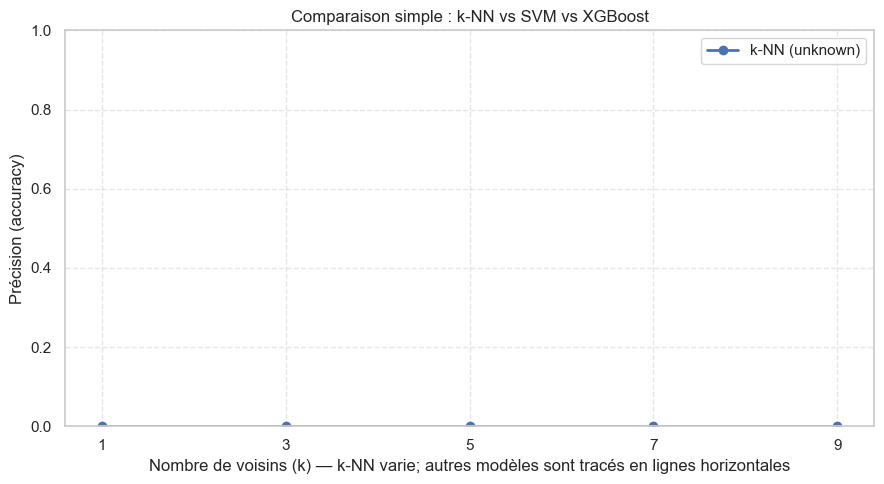

k-NN utilisé: unknown; k values: [1, 3, 5, 7, 9]


In [3]:
# Tracer 3 courbes : k-NN (selon k) + SVM et XGBoost (lignes horizontales)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Valeurs de k utilisées précédemment
k_values = [1, 3, 5, 7, 9]

# Récupérer les précisions k-NN si disponibles (préférence pour L1 (Manhattan) si présent)
knn_accs = None
used_distance = None
if 'results' in globals() and results:
    pref = 'L1 (Manhattan)'
    if pref in results:
        knn_accs = results[pref]['accuracies']
        used_distance = pref
    else:
        # prendre la première distance disponible
        first_key = list(results.keys())[0]
        knn_accs = results[first_key]['accuracies']
        used_distance = first_key
else:
    # fallback : si on n'a que l'accuracy k-NN (PCA) sous model_performance, tracer une ligne plate
    if 'model_performance' in globals() and 'k-NN (PCA)' in model_performance:
        v = model_performance['k-NN (PCA)']['accuracy']
        knn_accs = [v] * len(k_values)
        used_distance = 'k-NN (PCA) (flat)'
    else:
        knn_accs = [0.0] * len(k_values)
        used_distance = 'unknown'

# Récupérer SVM et XGBoost accuracies (si disponibles) depuis les variables ou model_performance
svm_acc = None
xgb_acc = None
if 'acc_svm' in globals():
    svm_acc = acc_svm
elif 'model_performance' in globals() and 'SVM (PCA)' in model_performance:
    svm_acc = model_performance['SVM (PCA)']['accuracy']
if 'acc_xgb' in globals():
    xgb_acc = acc_xgb
elif 'model_performance' in globals() and 'XGBoost (PCA)' in model_performance:
    xgb_acc = model_performance['XGBoost (PCA)']['accuracy']

# Tracé : k-NN comme courbe, SVM/XGBoost comme lignes horizontales (3 courbes visibles)
plt.figure(figsize=(9, 5))
sns.set(style='whitegrid')
# k-NN
plt.plot(k_values, knn_accs, marker='o', linewidth=2, label=f'k-NN ({used_distance})')
# SVM (ligne horizontale)
if svm_acc is not None:
    plt.plot(k_values, [svm_acc] * len(k_values), linestyle='--', marker='s', linewidth=2, label=f'SVM (PCA) = {svm_acc:.3f}')
# XGBoost (ligne horizontale)
if xgb_acc is not None:
    plt.plot(k_values, [xgb_acc] * len(k_values), linestyle=':', marker='^', linewidth=2, label=f'XGBoost (PCA) = {xgb_acc:.3f}')

plt.xticks(k_values)
plt.xlabel('Nombre de voisins (k) — k-NN varie; autres modèles sont tracés en lignes horizontales')
plt.ylabel('Précision (accuracy)')
plt.title('Comparaison simple : k-NN vs SVM vs XGBoost')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Afficher un résumé texte pour contextualiser le tracé
print(f'k-NN utilisé: {used_distance}; k values: {k_values}')
if svm_acc is not None: print(f'SVM accuracy = {svm_acc:.4f}')
if xgb_acc is not None: print(f'XGBoost accuracy = {xgb_acc:.4f}')


**Analyse Finale:**

La comparaison finale des modèles démontre de manière éclatante la supériorité des algorithmes avancés sur le k-NN pour cette tâche complexe. En utilisant les mêmes données réduites par PCA, le SVM et XGBoost ont presque doublé la précision, passant de 21,5% à plus de 40%, avec un léger avantage pour XGBoost (40,7%). Ce bond de performance s'explique par leur capacité à construire des modèles internes complexes et à trouver des frontières de décision non linéaires, là où k-NN, avec sa logique de voisinage simple, échouait. Ce gain de précision s'accompagne cependant d'un coût computationnel plus élevé, XGBoost étant le modèle le plus lent. En conclusion, bien que le choix d'un modèle puissant comme XGBoost soit clairement bénéfique, une précision de ~41% reste modeste et souligne les limites de cette approche, suggérant que des architectures spécialisées comme les réseaux de neurones convolutifs seraient nécessaires pour atteindre des performances de pointe.